In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Step 1: Define a function to add Gaussian noise to an image
def add_noise(img, noise_factor=0.2):
    """Add Gaussian noise to an image."""
    noisy = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
    return np.clip(noisy, 0., 1.)

In [3]:
# Step 2: Load CIFAR-10 dataset and normalize images to [0, 1]
(x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0  # Normalize images to [0, 1]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
# Step 3: Add noise to images
x_train_noisy = np.array([add_noise(img) for img in x_train])

In [11]:
# Step 4: Build the generator model
def build_generator():
    """Build and return the generator model."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(100,)),
        tf.keras.layers.Dense(8 * 8 * 128, use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((8, 8, 128)),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')
    ])
    return model


In [12]:
# Step 6: Build the GAN model
def build_gan(generator, discriminator):
    """Build and return the GAN model."""
    discriminator.trainable = False
    return tf.keras.Sequential([generator, discriminator])

In [13]:
# Step 7: Compile the discriminator and GAN models
def compile_models(generator, discriminator, gan):
    """Compile the discriminator and GAN models."""
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    gan.compile(optimizer='adam', loss='binary_crossentropy')

generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)
compile_models(generator, discriminator, gan)


In [14]:
# Step 8: Perform a single training step
def train_step(images, noise, labels_real, labels_fake):
    """Perform a single training step."""
    # Train Discriminator
    d_loss_real = discriminator.train_on_batch(images, labels_real)
    gen_imgs = generator(noise, training=False)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, labels_fake)
    d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])

    # Train Generator
    g_loss = gan.train_on_batch(noise, np.ones((len(noise), 1)))

    return d_loss, g_loss


In [21]:

# Step 9: Train the GAN
def train_gan(x_train_noisy, epochs=500, batch_size=64):
    """Train the GAN."""
    half_batch = batch_size // 2
    for epoch in range(epochs):
        idx = np.random.randint(0, x_train_noisy.shape[0], half_batch)
        imgs = x_train_noisy[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        labels_real = np.ones((half_batch, 1))
        labels_fake = np.zeros((half_batch, 1))

        d_loss, g_loss = train_step(imgs, noise, labels_real, labels_fake)

        if epoch % 50 == 0:
            print(f"{epoch}/{epochs} [D loss: {d_loss:.4f}] [G loss: {g_loss[0]:.4f}]")

train_gan(x_train_noisy)

0/500 [D loss: 1.2309] [G loss: 1.2329]
50/500 [D loss: 1.3733] [G loss: 1.3752]
100/500 [D loss: 1.5023] [G loss: 1.5041]
150/500 [D loss: 1.6168] [G loss: 1.6185]
200/500 [D loss: 1.7190] [G loss: 1.7205]
250/500 [D loss: 1.8089] [G loss: 1.8104]
300/500 [D loss: 1.8896] [G loss: 1.8909]
350/500 [D loss: 1.9628] [G loss: 1.9640]
400/500 [D loss: 2.0289] [G loss: 2.0301]
450/500 [D loss: 2.0893] [G loss: 2.0904]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


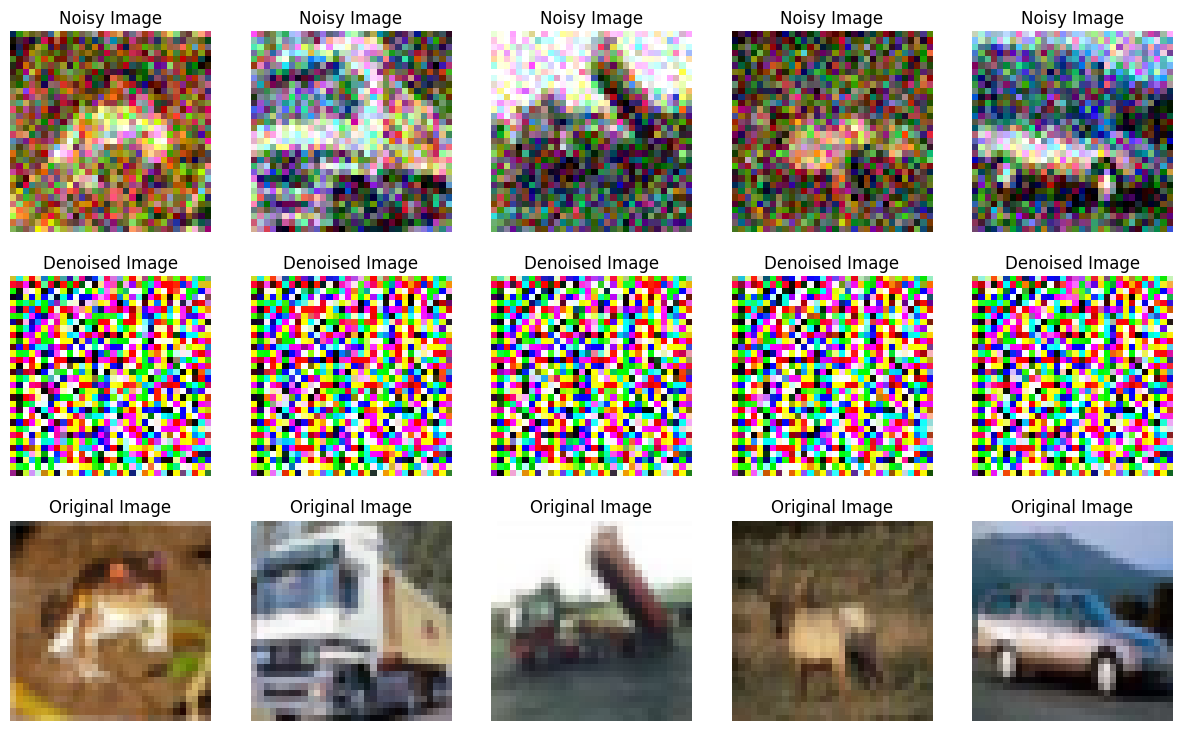

In [24]:
#Step 10: Evaluate and Display Results
def evaluate_model(x_test, x_test_noisy):
    """Evaluate and display results."""
    # Generating noise vectors
    noise = np.random.normal(0, 1, (len(x_test_noisy), 100))

    # Generating denoised images from noisy inputs
    denoised_imgs = generator.predict(noise)

    plt.figure(figsize=(15, 9))
    for i in range(5):
        plt.subplot(3, 5, i + 1)
        plt.imshow(np.clip(x_test_noisy[i], 0, 1))
        plt.title('Noisy Image')
        plt.axis('off')

        plt.subplot(3, 5, i + 6)
        denoised_img = (denoised_imgs[i] + 1) / 2
        plt.imshow(np.clip(denoised_img, 0, 1))
        plt.title('Denoised Image')
        plt.axis('off')

        plt.subplot(3, 5, i + 11)
        plt.imshow(np.clip(x_test[i], 0, 1))
        plt.title('Original Image')
        plt.axis('off')

    plt.show()

evaluate_model(x_train[:5], x_train_noisy[:5])
